In [2]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import datetime as dt
import yfinance as yf
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

c:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
start = dt.datetime(2010,1,1)
end = dt.datetime(2018,6,29)
df_aapl = yf.download('AAPL', start = start, end = end)

[*********************100%***********************]  1 of 1 completed


In [4]:
df_aapl = pd.DataFrame(df_aapl['Adj Close'])
df_aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2137 entries, 2010-01-04 to 2018-06-28
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2137 non-null   float64
dtypes: float64(1)
memory usage: 33.4 KB


In [5]:
SMA_short = 42
SMA_long = 252
df_aapl['SMA_short'] = df_aapl['Adj Close'].rolling(SMA_short).mean()
df_aapl['SMA_long'] = df_aapl['Adj Close'].rolling(SMA_long).mean()



<Figure size 432x288 with 0 Axes>

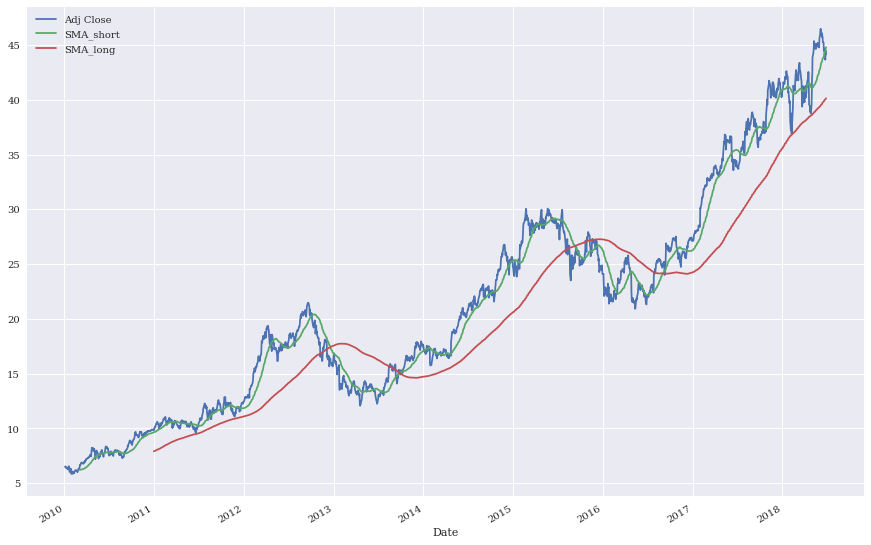

In [6]:
plt.figure()
df_aapl.plot(figsize = (15,10))

In [7]:
df_aapl['Position'] = np.zeros(len(df_aapl.index))

In [8]:
df_aapl[(df_aapl.SMA_long > df_aapl.SMA_short)].loc['Position'] = -1
df_aapl[(df_aapl.SMA_long < df_aapl.SMA_short)].loc['Position'] = 1

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [9]:
df_aapl.loc[(df_aapl.SMA_long > df_aapl.SMA_short), 'Position'] = -1
df_aapl.loc[(df_aapl.SMA_long < df_aapl.SMA_short), 'Position'] = 1

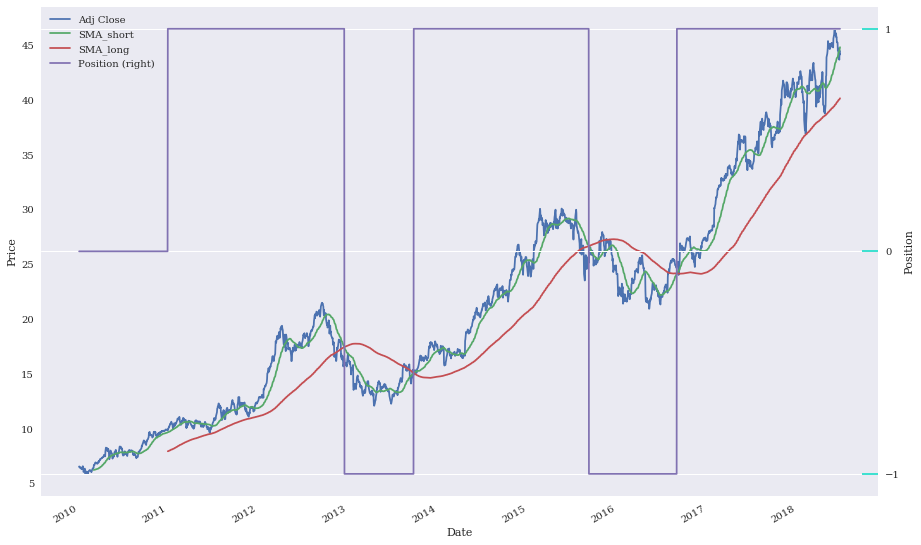

In [10]:
ax = df_aapl.plot(secondary_y='Position', figsize = (15,10))
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('Position')
ax.right_ax.tick_params(axis="y", direction="in", length=16, width=2, color="turquoise")
ax.right_ax.set_yticks([-1,0,1])

# Vectorized backtesting

In [11]:
df_aapl['daily_log_return'] = (np.log(df_aapl['Adj Close'])).diff()
df_aapl['strategy_daily_log_return'] = df_aapl['daily_log_return'] * df_aapl['Position'].shift(1) 

In [12]:
trading_days_per_year = 252
df_aapl.dropna(inplace = True)


In [13]:
buy_hold_returns = np.exp(df_aapl['daily_log_return'].sum() ) -1
strategy_returns = np.exp(df_aapl['strategy_daily_log_return'].sum()) -1
print(f'The returns for buy and hold is {buy_hold_returns: .2f} \nThe returns for the SMA strategy is {strategy_returns:.2f}')

The returns for buy and hold is  3.51 
The returns for the SMA strategy is 4.42


In [14]:
buy_hold_ann_vol = df_aapl['daily_log_return'].std() * 252 ** 0.5
strategy_ann_vol = df_aapl['strategy_daily_log_return'].std() * 252 ** 0.5
print(f'The annulaized volatility for buy and hold is {buy_hold_ann_vol: .5f} \nThe annualized volatility for the SMA strategy is {strategy_ann_vol:.5f}')

The annulaized volatility for buy and hold is  0.25035 
The annualized volatility for the SMA strategy is 0.25027


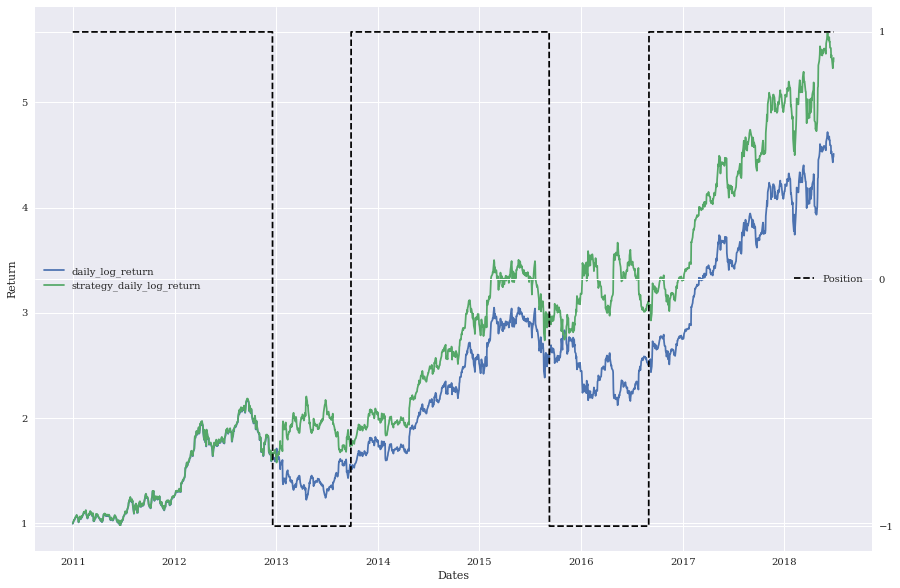

In [15]:
fig, ax = plt.subplots(figsize = (15,10))

plt.plot(np.exp(df_aapl['daily_log_return'].cumsum() ))
plt.plot(np.exp(df_aapl['strategy_daily_log_return'].cumsum()))
plt.xlabel('Dates')
plt.ylabel('Return')
plt.legend(loc = 6)
ax2 = ax.twinx()
plt.plot(df_aapl.Position, 'k--')
plt.yticks([-1,0,1])
plt.legend(loc = 7)

# Optimization

In [16]:
from itertools import product #product(a,b) is a like a nested for loop with B in A

In [17]:
sma_short = range(20, 61, 4)
sma_long = range(180, 281, 10)


In [18]:
results = pd.DataFrame()
for i_sma_short, i_sma_long in product(sma_short, sma_long):
    df_aapl2 = pd.DataFrame(df_aapl['Adj Close'])
    df_aapl2.dropna(inplace = True)
    df_aapl2['daily_log_returns'] = (np.log(df_aapl2['Adj Close'])).diff()
    df_aapl2['SMA_short'] = df_aapl2['Adj Close'].rolling(i_sma_short).mean()
    df_aapl2['SMA_long'] = df_aapl2['Adj Close'].rolling(i_sma_long).mean()
    df_aapl2.dropna(inplace = True)
    df_aapl2['Position'] = np.where(df_aapl2['SMA_short'] > df_aapl2['SMA_long'], 1, -1)
    df_aapl2['strategy_daily_log_returns'] = df_aapl2['Position'].shift(1) * df_aapl2['daily_log_returns']
    df_aapl.dropna(inplace = True)
    perf = np.exp(df_aapl2[['daily_log_returns', 'strategy_daily_log_returns']].sum())
    results = results.append(pd.DataFrame(
        {'SMA_short': i_sma_short,
        'SMA_long': i_sma_long,
        'Strategy': perf['strategy_daily_log_returns'],
        'Buy And Hold': perf['daily_log_returns'],
        'Out':  perf['strategy_daily_log_returns'] - perf['daily_log_returns']}, index = [0]), ignore_index = True)


In [19]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SMA_short     121 non-null    int64  
 1   SMA_long      121 non-null    int64  
 2   Strategy      121 non-null    float64
 3   Buy And Hold  121 non-null    float64
 4   Out           121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [20]:
results.sort_values('Strategy', ascending = False).head(7)

,SMA_short,SMA_long,Strategy,Buy And Hold,Out
81,48,220,5.465374,3.790128,1.675245
71,44,230,5.184487,4.015824,1.168663
45,36,190,5.156071,3.738212,1.417859
50,36,240,5.146053,3.709245,1.436808
37,32,220,5.137023,3.790128,1.346894
5,20,230,5.133990,4.015824,1.118165
4,20,220,5.071739,3.790128,1.281610
